<a href="https://colab.research.google.com/github/ibadjanah/Twitter-classification/blob/main/Untitled11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import random

from tqdm.auto import tqdm
from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split

from transformers import RobertaTokenizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import RobertaModel
from transformers.modeling_outputs import SequenceClassifierOutput
import copy
from tqdm.auto import tqdm
from datasets import DatasetDict
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
from transformers import EarlyStoppingCallback

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed_all(RANDOM_STATE)

In [ ]:
from google.colab import drive


drive.mount('/content/drive/', force_remount=True)
dir = '/content'

dataset = load_dataset(
    'csv',
    data_files=f'{dir}/train.csv',
    column_names=['id','keyword','location', 'text', 'label'],
)

Mounted at /content/drive/


In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'keyword', 'location', 'text', 'label'],
        num_rows: 7614
    })
})

Наш датасет очень, очень захламлён. Сам автор написал, что могут быть пустые поля в keyword и location. Давайте объективно глянем на датасет. Локаций тут тьма, кто-то пишет млечный путь, кто-то ничего, в общем это будет мешать модели установить закономерности. Также обратим внимание на ссылки, нам не важны сайты, но они начинаются с http:// и их нужно почистить, они не несут полезной информации. Также мусором можно назвать обращения,хэштеги, инородные символы. Хэштег не скажет точно ли катастрофа или нет.
Нам с этим очень помогут регулярные выражения. Ну также удалим дубликаты, нам они будут мешать при обучении, как минимум, модель может немного переобучиться от одинаковых примеров.
Тут возникла проблема. Я вместе с ненеужными тегами удаляю такие теги, как #RIP и т.п. Ну всё же иногда теги занимают чуть ли не половину всего текста. Мы можем с одной стороны дать модели хэштеги и позволить ей самой определять нужные и ненужные, но датасет очень маленький (было бы тысяч 20 хотя бы, а тут 6 тысяч без дубликатов). Мы пойдём на компромисс и превратим хэштеги #god в слова -> god

In [ ]:
def clean_tweet(text):
    text = re.sub(r'http\S+', '', text)  # Удаление ссылок
    text = re.sub(r'@\w+', '', text)      # Удаление упоминаний
    text = re.sub(r'#', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^A-Za-z0-9\s.,:;?!\-]', '', text) #удаление всего not-English алфавита
    text = text.strip()                    # Удаление пробелов в начале и конце
    return text

In [ ]:
train_pd = pd.DataFrame(dataset['train'])
train_pd = train_pd.drop('id', axis=1)
train_pd = train_pd.drop('location', axis=1)
train_pd = train_pd.groupby('text', as_index=False).first()
train_pd['text'] = list(map(clean_tweet, train_pd['text']))
train_pd = train_pd.explode('text')
train_pd = train_pd.groupby('text', as_index=False).first()
train_pd = train_pd.drop_duplicates().reset_index(drop=True)
train_pd['label'] = pd.to_numeric(train_pd['label'], errors='coerce')
train_pd = train_pd[train_pd['label'].isin([0, 1])].reset_index(drop=True)
train_pd['label'] = train_pd['label'].astype(int)
train_pd

,text,keyword,label
0,! Residents Return To Destroyed Homes As Washi...,wildfire,1
1,- Cleveland Heights Shaker Heights fight bligh...,blight,0
2,- Man gently dabbed the cotton rag across each...,wounds,0
3,- Pandemonium In Aba As Woman Delivers Baby Wi...,pandemonium,0
4,-- causing the entire sky around their battle ...,violent%20storm,0
...,...,...,...
6903,your turn ??,electrocute,0
6904,youre correct it is coming from both sides. Ma...,inundated,0
6905,youre not injured anymore? ??,injured,0
6906,youre the snowstorm Im purified. the darkest f...,snowstorm,0


In [ ]:
train = Dataset.from_pandas(train_pd)
train

Dataset({
    features: ['text', 'keyword', 'label'],
    num_rows: 6908
})

Ну это выглядит поприятнее. Далее нам нужно выбрать модель и обучить. Я помню мне говорили взять какой-то простой датасет и обучить на нём две модельки и сравнить. Ну моделй очень много и я бы хотел использовать трансформеры здесь (RNN, LSTM и прочие дают результаты хуже и с ними много мучаться). Поэтому я обучу одну модель с замороженным backbone и размороженным, сравню их и сделаю выводы. Будет две модели, но я надеюсь, что это не повлиет на оценку. Я планирую в следующем семестре написать что-то мощное, чтобы сдать Елене Владимировне, это проект просто для зачёта.
Я разбирал устройство трансформера в виде класса из статьи Attention is all you need и думаю, что будет проще загрузить модель из hugging face. Остаётся только выбрать нужную. Можно вообще взять какую-нибудь базу, типо Bert

Я зашёл на hugging face и взял RoBERT, который обучен на постах из facebook. Bert и RoBert очень похожи и их реализация практически идентична, но RoBERT немного лучше. К тому же для классификации постов с твиттера будет полезна модель, которая обучена на постах в facebook

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-large-mnli')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


Существует несколько способов токенизации, когда у нас несколько колонок. И самый простой - объединить два столбца и разделить их служебным токеном. Самый простой не только для меня, но и для модели. Хотя я только новичок. Хотя механизм attention вроде как параллельно всё обрабатывает, я не знаю, как будет действовать с несколькими колонками.

In [ ]:
def tokenize(dataset: Dataset, tokenizer: RobertaTokenizer):
    combined_text = [f"{text} [KEYWORD] {keyword}" for text, keyword in zip(dataset["text"], dataset["keyword"])]

    tokenized_text = tokenizer(
        combined_text,
        truncation=True,
        padding='max_length',
        max_length=512
    )

    return tokenized_text

In [ ]:
train = train.map(tokenize, batched=True, fn_kwargs={"tokenizer": tokenizer})
train = train.remove_columns(["keyword"])
train

Map:   0%|          | 0/6908 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 6908
})

In [ ]:
train = train.train_test_split(test_size=0.10).shuffle(seed=42)
train

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 6217
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 691
    })
})

Вот и выполнен Препроцессинг данных. Мы избавились от мусора, как смогли, и токенизировали текст.

In [ ]:
class TransformerClassificationModel(nn.Module):
    def __init__(self, base_transformer_model = 'roberta-large-mnli', num_labels: int = 2):
        super().__init__()
        self.num_labels = num_labels

        self.backbone = RobertaModel.from_pretrained(base_transformer_model)
        self.classifier = nn.Linear(self.backbone.config.hidden_size, num_labels)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        outputs = self.backbone(input_ids, attention_mask)
        embeddings = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(embeddings)

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits.view(-1, self.num_labels), labels.view(-1))

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [ ]:
def freeze_backbone_function(model: TransformerClassificationModel):
    for param in model.backbone.parameters():
        param.requires_grad = False
    return model

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')

    return {
        'eval_accuracy': accuracy,
        'eval_precision': precision,
        'eval_recall': recall,
        'eval_f1': f1  # Убедитесь, что это имя соответствует тому, что указано в TrainingArguments
    }

In [ ]:
def train_transformer(
    model: TransformerClassificationModel,
    tokenizer: BertTokenizer,
    dataset: DatasetDict,
    freeze_backbone: bool = True,
    output_dir: str = "./results",
    batch_size: int = 8,
    num_epochs: int = 3,
    learning_rate: float = 1e-5,
    weight_decay: float = 0.001,
    evaluation_strategy: str = "epoch",
    save_total_limit: int = 3,
    remove_unused_columns: bool = True,
    report_to: str = "none",
    padding: bool = True,
    logging_steps: int = 1,
    metric_for_best_model: str = "eval_f1",  # или любое другое метрика
    greater_is_better: bool = True,  # зависит от метрики
):

    model = copy.copy(model)

    if freeze_backbone:
        model = freeze_backbone_function(model).to(device)

    training_args = TrainingArguments(
        output_dir=output_dir,
        evaluation_strategy=evaluation_strategy,
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        weight_decay=weight_decay,
        save_total_limit=save_total_limit,
        num_train_epochs=num_epochs,
        remove_unused_columns=remove_unused_columns,
        report_to=report_to,
        logging_steps=logging_steps,
        load_best_model_at_end=True,
        metric_for_best_model=metric_for_best_model,
        save_strategy="epoch"
    )

    data_collator = DataCollatorWithPadding(
        tokenizer=tokenizer,
        padding=padding,
    )


    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset["train"],
        eval_dataset=dataset["test"],
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

    trainer.train()
    results = trainer.evaluate()
    return model

In [ ]:
roberta = TransformerClassificationModel()


In [ ]:
import shutil
shutil.rmtree(f'{dir}/Roberta_with_freezed_backbone', ignore_errors=True)

Roberta_with_freezed_backbone = train_transformer(
    model=roberta,
    tokenizer=tokenizer,
    dataset=train,
    freeze_backbone=True,
    output_dir=f'{dir}/Roberta_with_freezed_backbone',
    batch_size=256,
    num_epochs=20,
    learning_rate=1e-1,
    weight_decay=1e-2,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-20-3e591870b0c7>:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


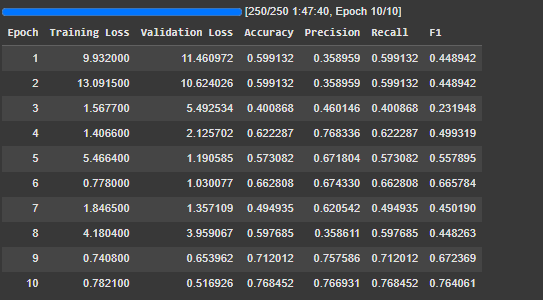

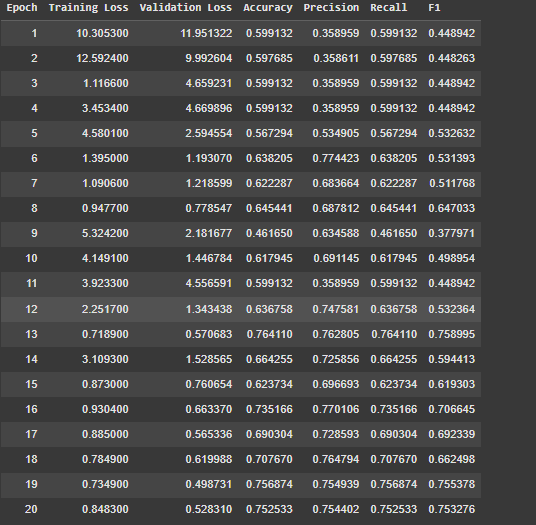

In [ ]:
!zip -r /content/Roberta_with_freezed_backbone.zip {dir}/Roberta_with_freezed_backbone
from google.colab import files
files.download('/content/Roberta_with_freezed_backbone.zip')

In [ ]:
roberta = TransformerClassificationModel()
import shutil
shutil.rmtree(f'{dir}/Roberta_with_unfreezed_backbone', ignore_errors=True)

Roberta_with_freezed_backbone = train_transformer(
    model=roberta,
    tokenizer=tokenizer,
    dataset=train,
    freeze_backbone=False,
    output_dir=f'{dir}/Roberta_with_unfreezed_backbone',
    batch_size=256,
    num_epochs=10,
    learning_rate=1e-1,
    weight_decay=1e-2,
)